In [1]:
import numpy as np
import if2 as if2
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Dane 
FXspot = 4.75
FXspotData=np.linspace(FXspot-1,FXspot+1,100)
tenor = ["1W", "1M", "3M", "6M", "9M", "1Y"]
yf = [1/52, 1/12, 3/12, 6/12, 9/12, 1]
rate_ccy = [0.02, 0.0225, 0.025, 0.0265, 0.0275, 0.0285]
swapp = [20, 80, 220, 420, 650, 900]

data = pd.DataFrame({"tenor":tenor, "yf": yf, "rate_ccy": rate_ccy, "swapp": swapp})
cc_curves = if2.cc_imp_curves(FXspot,data.tenor,data.yf,data.rate_ccy,data.swapp)

rate_pln = cc_curves[5]
df_pln = cc_curves[4]
rate_eur = cc_curves[3]
df_eur = cc_curves[2]
#plt.plot(tenor,rate_eur,marker='o',label="Rate EUR")
#plt.plot(tenor,rate_pln,marker='o',label="Rate PLN")
#plt.legend()

In [3]:
FXspot = 4.75

Opt_type = "Call"
omega    = 2.0*float(Opt_type.upper()=="CALL")-1
vol      = 0.2
tau      = 1.0
T        = 1.0
df_f     = if2.int_df(T, yf, df_eur) 
df_d     = if2.int_df(T, yf, df_pln)

type_atm      = 'ATM-0D'
print("*** Delta spot/fwd ***")
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
print(f"K_ATM-0D, delta {'  z premią' if is_pi else 'bez premii'}: {K_ATM: 6.4f}")

is_pi         = False # True / False if delta jest z / bez premii
K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_d,tau)
print(f"K_ATM-0D, delta {'  z premią' if is_pi else 'bez premii'}: {K_ATM: 6.4f}")

type_atm      = 'ATM-F'
print("*** Delta spot/fwd, delta z/bez premii ***")
is_pi         = True # True / False if delta jest z / bez premii
K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,vol,df_d,df_f,tau)
print(f"K_ATM-F                     {K_ATM: 6.4f}")


*** Delta spot/fwd ***
K_ATM-0D, delta   z premią:  4.7442
K_ATM-0D, delta bez premii:  4.8460
*** Delta spot/fwd, delta z/bez premii ***
K_ATM-F                      4.8400


In [4]:
def vv_int5(K,smile_data):
    (K1,sig1,K2,sig2,K3,sig3) = smile_data
    x1 = (np.log(K/K2)*np.log(K/K3))/(np.log(K1/K2)*np.log(K1/K3))
    x2 = (np.log(K/K1)*np.log(K/K3))/(np.log(K2/K1)*np.log(K2/K3))
    x3 = (np.log(K/K1)*np.log(K/K2))/(np.log(K3/K1)*np.log(K3/K2))
    sigmaK = x1*sig1 + x2*sig2 + x3*sig3
    return sigmaK

FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

FXfwd=FXspot*df_f/df_d

type_atm      = 'ATM-0D'
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,sig_atm,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,T)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,T)

smile_data = K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c

vol = vv_int5(K_ATM,smile_data)
vol


0.0905

---
# Wycena Vanna-Volga

In [5]:
FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

FXfwd=FXspot*df_f/df_d

type_atm      = 'ATM-0D'
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,sig_atm,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,T)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,T)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)

N=1
omega=1
K=1.205
BS_price = if2.ValueBS(omega, FXspot, sig_atm, df_d, df_f, K, T, 1)
print(BS_price)
VV_price = if2.VV_value(omega, FXspot, df_d, df_f, K, T, N, smile_data)
print(VV_price)

0.02460395846893204
0.02467202926647373


In [6]:
FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

sig_25strg = sig_atm + sig_bf

FXfwd=FXspot*df_f/df_d

type_atm      = 'ATM-0D'
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM      = if2.ATM_Strike(type_atm,is_pi,FXspot,sig_atm,df_d,df_d,tau)
K_25C      = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,T)
K_25P      = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,T)
K_25C_STRG = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25strg,df_d,df_f,T)
K_25P_STRG = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25strg,df_d,df_f,T)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)

N     = 1
omega = 1
K     = 1.205

BS_priceC = if2.ValueBS( omega, FXspot, sig_25strg, df_d, df_f, K_25C_STRG, T, 1)
BS_priceP = if2.ValueBS(-omega, FXspot, sig_25strg, df_d, df_f, K_25P_STRG, T, 1)
print(BS_priceC+BS_priceP)

VV_priceC = if2.VV_value( omega, FXspot,df_d,df_f,K_25C_STRG,T,N,smile_data)
VV_priceP = if2.VV_value(-omega, FXspot,df_d,df_f,K_25P_STRG,T,N,smile_data)
print(VV_priceC+VV_priceP)

0.016778291575980264
0.01674506764570203


In [7]:
def VV_value_t(omega,FXspot,df_d,df_f,K,T,N,smile_data):
    sigK  = if2.vv_int1s(K,smile_data)
    value = if2.ValueBS(omega, FXspot, sigK, df_d, df_f, K, T, N)
    return value

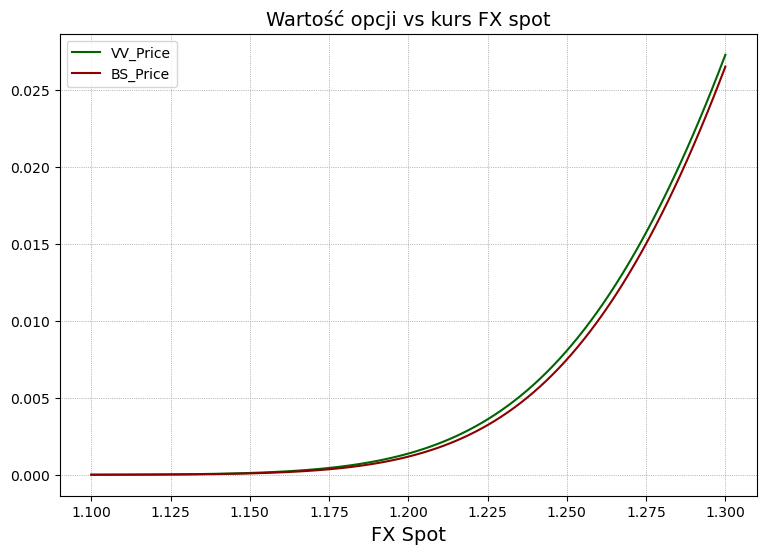

In [8]:
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wartość opcji vs kurs FX spot",fontsize=14)
axl.set_xlabel("FX Spot",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)

FXspot_set=np.linspace(1.1,1.3,100)
omega=1
K=1.3

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)
plt.plot(FXspot_set,[VV_value_t(omega,S,df_d,df_f,K,T,1,smile_data) for S in FXspot_set],color="darkgreen",linewidth=1.5,label="VV_Price")
plt.plot(FXspot_set,[if2.ValueBS(omega,S,sig_atm,df_d,df_f,K,T,1) for S in FXspot_set],color="darkred",linewidth=1.5,label="BS_Price")
plt.legend()

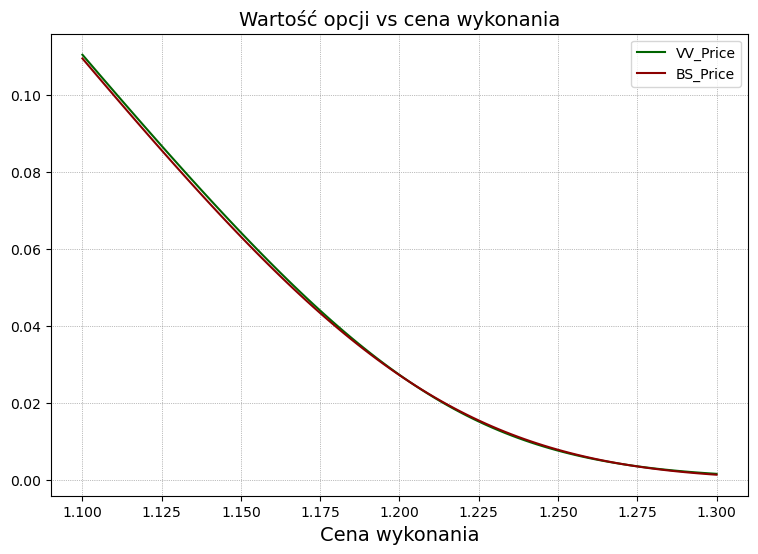

In [9]:
fig, axl=plt.subplots(figsize=(9,6))
axl.set_title("Wartość opcji vs cena wykonania",fontsize=14)
axl.set_xlabel("Cena wykonania",fontsize=14)
axl.grid(color="gray",which="both",linestyle=':',linewidth=0.5)

K_set = np.linspace(1.1,1.3,100)
omega=1
FXspot = 1.205
smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)

plt.plot(K_set,[VV_value_t(omega,FXspot,df_d,df_f,K,T,1,smile_data) for K in K_set],color="darkgreen",linewidth=1.5,label="VV_Price")
plt.plot(K_set,[if2.ValueBS(omega,FXspot,sig_atm,df_d,df_f,K,T,1) for K in K_set],color="darkred",linewidth=1.5,label="BS_Price")
plt.legend()

---
# Wyznaczanie jednostkowych kosztów *overhedge*

In [10]:
FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

sig_25strg = sig_atm + sig_bf

FXfwd = FXspot*df_f/df_d

type_atm      = 'ATM-0D'
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,sig_atm,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,T)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,T)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)

omega = 1
K     = 1.205

Vol_risk_cost=if2.VolRiskCost(FXspot,df_d,df_f,T,smile_data)
print(Vol_risk_cost)

[ 1.57144782e-17 -1.99434001e-04  2.62950323e-04]


---
# Wycena Vanna-Volga via koszty *overhedge*

In [11]:
FXspot = 1.205
T      = 94/365
df_f   = 0.994585501
df_d   = 0.990275201
tau    = T
sig_atm = 0.0905
sig_rr  =-0.0050
sig_bf  = 0.0013
sig_25c = sig_atm + 0.5*sig_rr + sig_bf
sig_25p = sig_atm - 0.5*sig_rr + sig_bf

sig_25strg = sig_atm + sig_bf

FXfwd = FXspot*df_f/df_d

type_atm      = "ATM-0D"
is_spot_delta = True # True / False if spot / fwd delta
is_pi         = True # True / False if delta jest z / bez premii

K_ATM = if2.ATM_Strike(type_atm,is_pi,FXspot,sig_atm,df_d,df_f,tau)
K_25C = if2.StrikeFromDelta(is_spot_delta,is_pi, 1, 0.25,FXspot,sig_25c,df_d,df_f,T)
K_25P = if2.StrikeFromDelta(is_spot_delta,is_pi,-1,-0.25,FXspot,sig_25p,df_d,df_f,T)

smile_data = (K_25P,sig_25p,K_ATM,sig_atm,K_25C,sig_25c)

omega=1
K=1.3

def VV_value2(omega,FXspot,df_d,df_f,K,T,sig_atm,Vol_risk_cost):
    VegaK     = if2.VegaBS(FXspot, sig_atm, df_d, df_f, K, T, 1)
    VolgaK    = if2.VolgaBS(FXspot, sig_atm, df_d, df_f, K, T, 1)
    VannaK    = if2.VannaBS(FXspot, sig_atm, df_d, df_f, K, T, 1)
    Vol_sensi = np.array([VegaK,VolgaK,VannaK])
    OH        = Vol_risk_cost.dot(Vol_sensi)
    Value_BS  = if2.ValueBS(omega, FXspot, sig_atm, df_d, df_f, K, T, 1)
    value     = Value_BS+OH
    return value

VV_price  = if2.VV_value(omega,FXspot,df_d,df_f,K,T,1,smile_data)
VV_price3 = if2.VV_value3(omega,FXspot,df_d,df_f,K,T,sig_atm,Vol_risk_cost)
print("Wycena VV via koszty overhegde %6.4f" %VV_price3)
print("Wycena VV %6.4f" %VV_price)

Wycena VV via koszty overhegde 0.0016
Wycena VV 0.0016
